# part 2

### Loading the model and analysis from part 1

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv('./data/laptopData.csv')

# Rename the column 'Unnamed: 0' to 'ID'
data.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Define the adjusted exchange rate based on a specific example
price_in_pkr_example = 47895.5232  # Example price in PKR
target_price_usd = 1000  # Desired average price in USD
adjusted_exchange_rate = price_in_pkr_example / target_price_usd

# Remove rows with NaN values in the 'Price' column
data = data[~data['Price'].isna()]


# Convert the 'Price' column to USD and replace the original column
data['Price'] = data['Price'] / adjusted_exchange_rate

# Create a copy of the original DataFrame
copy_data = data.copy()

# Display rows number
print("Number of rows in the original DataFrame:", data.shape[0])

#display data types of each column
print("Data types:" )
print(data.dtypes)

# Display the first few rows of the modified DataFrame
data.head()

Number of rows in the original DataFrame: 1273
Data types:
ID                  float64
Company              object
TypeName             object
Inches               object
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object


,ID,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1490.299686
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,1000.000000
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,639.642245
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2822.713418
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,2006.363050


## preproccing

In [2]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical features to numeric using Label Encoding
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()
model_data = copy_data.copy()

for feature in categorical_features:
    model_data[feature] = encoder.fit_transform(model_data[feature])

# Remove the 'ID' column
model_data = model_data.drop(columns=['ID'])

# Select all numeric features (after encoding)
numeric_features = model_data.select_dtypes(include=[np.number])
print("Encoded columns done.")

Encoded columns done.


## Basic Model Pipeline 

In [3]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Feature selection and target variable
X = model_data.drop(columns=['Price'])
y = model_data['Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)
    
# Make predictions
y_pred = model.predict(X_test)

print("Model training complete.")

Model training complete.


## Results of the basic pipeline

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Model Performance Metrics:")
print(f"RMSE: {rmse:.2f}k")
print(f"MAE: {mae:.2f}k")
print(f"R2 Score: {r2:.3f}")


Model Performance Metrics:
RMSE: 313.30k
MAE: 193.69k
R2 Score: 0.845


# Error Analysis
After running the basic model, we will analyze its errors to identify areas for improvement.

### A. Predicted vs Actual Price


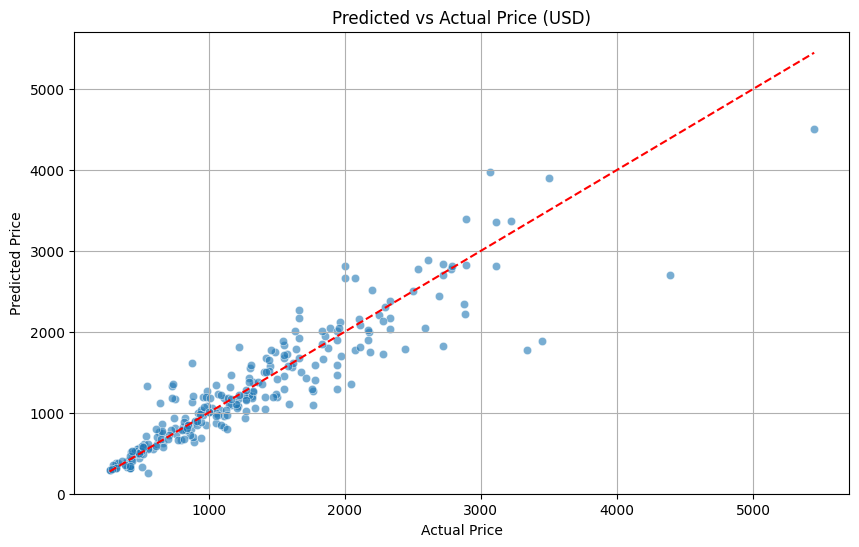

In [5]:
# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Price (USD)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()

### B. Error Distribution

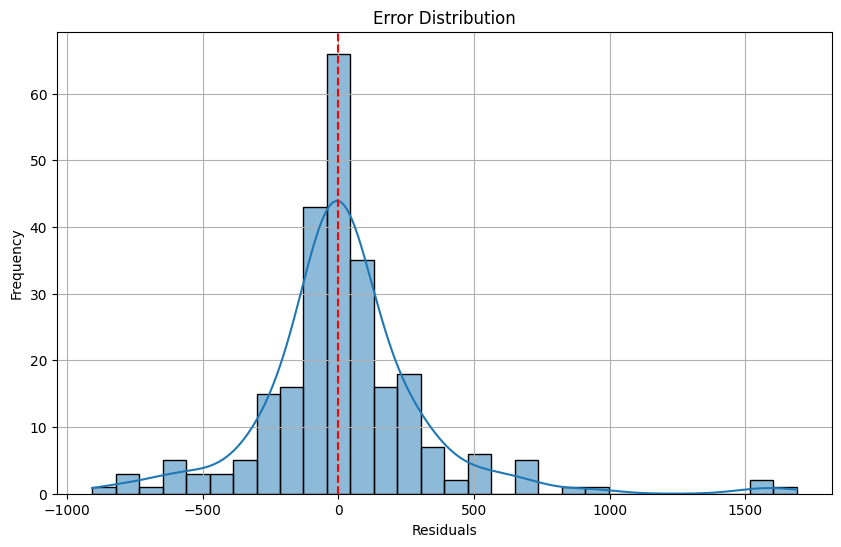

In [6]:
# Calculate residuals
residuals = y_test - y_pred

# Plot Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual (Perfect Prediction)')
plt.title("Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### C. Features Importance

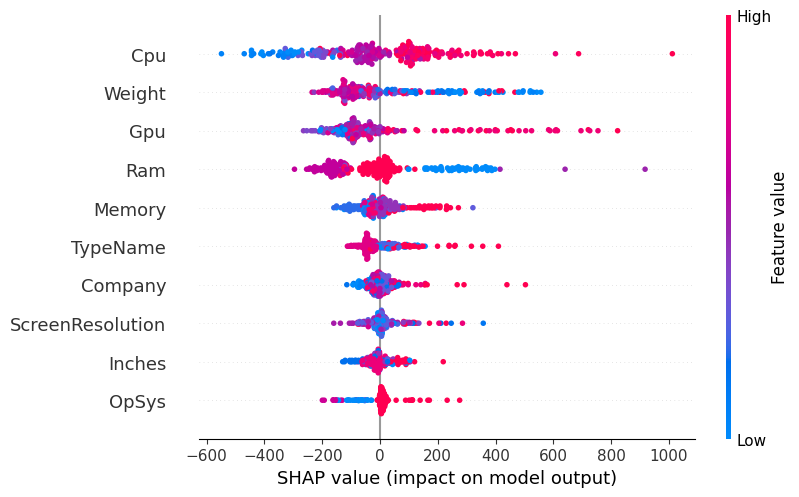

In [7]:
import shap

# Calculate SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot SHAP beeswarm plot
shap.plots.beeswarm(shap_values)

### D. Overestimations and Underestimations by Price

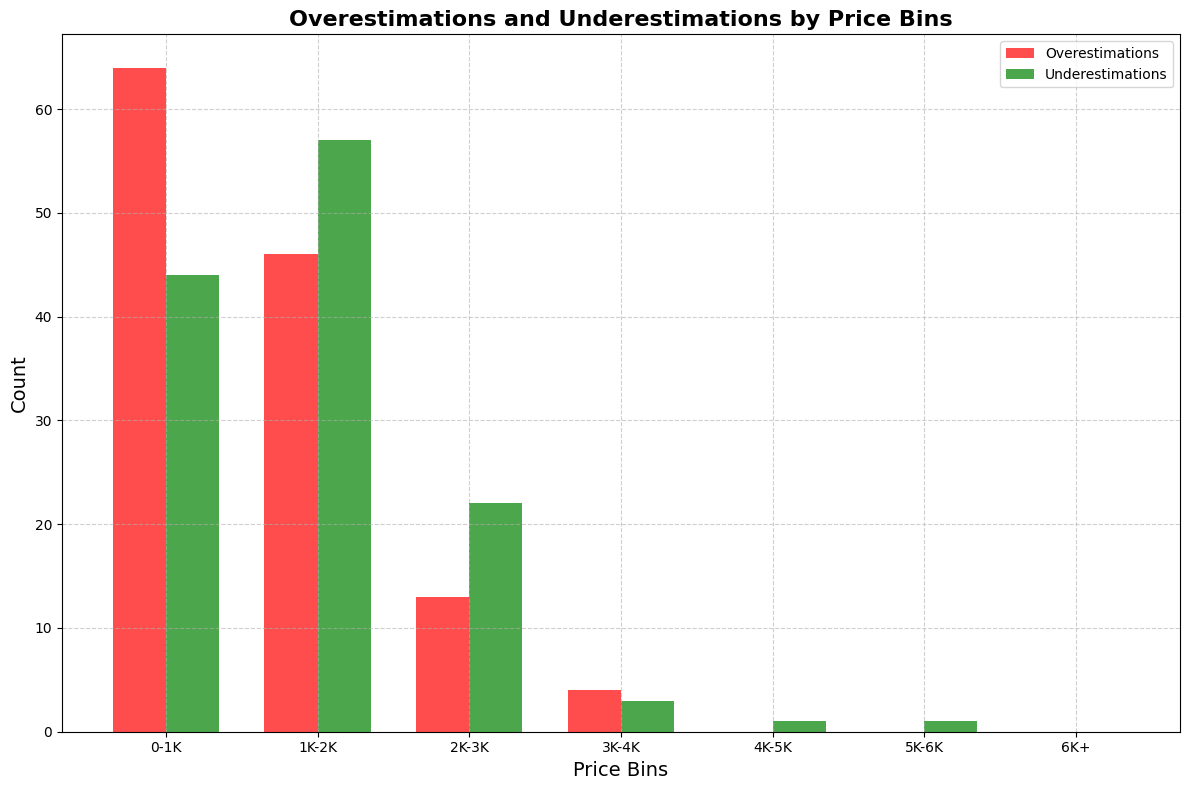

In [8]:

# Define bins for price ranges
price_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
price_labels = ['0-1K', '1K-2K', '2K-3K', '3K-4K', '4K-5K', '5K-6K', '6K+']
y_test_binned = pd.cut(y_test, bins=price_bins, labels=price_labels)

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred,
    'Residual': residuals,
    'Price Range': y_test_binned
})

# Calculate overestimations and underestimations by price range
over_under_estimations = analysis_df.groupby('Price Range').apply(
    lambda group: pd.Series({
        'Overestimations': (group['Residual'] < 0).sum(),
        'Underestimations': (group['Residual'] > 0).sum()
    })
).reset_index()

# Plot overestimations and underestimations by price range
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(over_under_estimations))

plt.bar(index, over_under_estimations['Overestimations'], bar_width, label='Overestimations', color='red', alpha=0.7)
plt.bar(index + bar_width, over_under_estimations['Underestimations'], bar_width, label='Underestimations', color='green', alpha=0.7)

plt.ylabel('Count', fontsize=14)
plt.xlabel('Price Bins', fontsize=14)
plt.title('Overestimations and Underestimations by Price Bins', fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, over_under_estimations['Price Range'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### After loading the model and analysis from part 1 let's start part 2
<hr>

# Error Analysis Conclusions & work plan

#### **Error Analysis Conclusions:**
1. **Predicted vs. Actual Price**:
   - The scatterplot of predicted vs. actual prices shows that the model performs well for most cases, with data points closely following the diagonal red line.
   - However, outliers, where the predicted prices deviate significantly from the actual values, indicate specific cases where the model fails. These may arise due to insufficient representation of certain price ranges or inadequate feature engineering.

2. **Error Distribution**:
   - The residuals are mostly centered around zero, indicating the model performs reasonably well. However, outliers in both positive and negative residuals highlight cases where the model struggles to make accurate predictions.
   - Outliers on both positive and negative ends highlight specific cases where the model struggles to generalize, possibly due to edge cases or insufficient representation of certain data points in the training set.

3. **SHAP Value Analysis**:
   - Features like **CPU**, **RAM**, and **GPU** have strong predictive power but show high variability in their contributions. This variability might reflect complex, non-linear interactions that the model struggles to fully capture.
   - Minimal impact from features like **Operating System** and **Screen Resolution** suggests they might not contribute significantly to the model's accuracy and could be revisited or transformed for better representation.
   - The high variability in the contributions of **GPU** and **Weight** indicates that the model may not be effectively capturing their complex relationships with price. Addressing this could lead to improved prediction accuracy.

4. **Overestimations and Underestimations by Price Range**:
   - Most overestimations occur in the lower price ranges (0-1K USD), which could indicate the model struggles to capture the nuances of cheaper laptops.
   - Underestimations are prevalent in the mid-price range (1K-3K USD), suggesting that the model underestimates the value of mid-tier laptops, potentially due to feature interactions or insufficient data diversity.



#### **Work Plan for Error Reduction**
1. **Feature Engineering Enhancements**:
   - **Simplify Complex Features**:
     Transform features like **ScreenResolution** into categorical bins (e.g., HD, Full HD, Retina) and refine **GPU** into performance-based categories.
   - **Reduce Noise in Key Features**:
     Normalize or categorize features with high variability, such as **Weight** and **RAM**, to make their relationships with price more interpretable.
   - **Create Interaction Features**:
     Engineer new features that capture interactions between influential variables like **CPU** and **RAM**, which often jointly determine performance.

2. **Outlier Handling**:
   - Analyze residual outliers in both overestimations and underestimations to identify patterns. Remove extreme cases and transform features contributing disproportionately to errors.
   - Apply transformation techniques for features with wide ranges, like **Weight** or **Price**.

3. **Data Cleaning and Augmentation**:
   - Address any inconsistencies or noise in influential features such as **GPU**. For example, standardize formats or group similar GPUs together to enhance model understanding.
   - Ensure uniform handling of missing values, with strategies tailored to each feature type (e.g., median imputation for numeric features, most frequent value for categorical ones).

4. **Targeted Data Sampling**:
   - Focus on increasing representation for underrepresented price ranges (e.g., budget laptops) by using techniques like stratified sampling or synthetic data generation.
   - Conduct stratified analysis for each price range (low, mid, high) to ensure that key patterns and trends are captured comprehensively.

5. **Hyperparameter Tuning** (to be detailed in Section B):
   - Plan systematic optimization of the XGBoost model parameters, such as learning rate, depth, and number of estimators, using GridSearchCV or Bayesian optimization. This will ensure the model is fine-tuned for better performance.

6. **Pipeline Refinement**:
   - Automate preprocessing steps such as feature encoding, scaling, and imputation into a reproducible pipeline.
   - Validate preprocessing transformations (e.g., encoding, binning) through cross-validation to ensure robustness and consistency.

7. **Focus on Explainability**:
   - Use SHAP values to explain outlier cases and identify specific feature contributions to errors. This will inform the transformation or augmentation of these features.

# Improving Model Performance

In [9]:
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Load the dataset and preprocess
improve_data = model_data.copy()

# Impute missing values
imputer = SimpleImputer(strategy='median')
numeric_features = improve_data.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    improve_data[feature] = imputer.fit_transform(improve_data[[feature]])

# Transform ScreenResolution into categories (e.g., HD, Full HD, Retina)
def categorize_resolution(resolution):
    if isinstance(resolution, str):
        if "1920x1080" in resolution:
            return "Full HD"
        elif "2560x" in resolution or "Retina" in resolution:
            return "High Res"
        elif "1366x768" in resolution:
            return "HD"
        else:
            return "Other"
    else:
        return "Other"

improve_data['Resolution_Category'] = improve_data['ScreenResolution'].apply(categorize_resolution)
improve_data['Resolution_Category'] = LabelEncoder().fit_transform(improve_data['Resolution_Category'])
improve_data.drop(columns=['ScreenResolution'], inplace=True)

# Scale numeric features except for the target
scaler = MinMaxScaler()
numeric_features = improve_data.select_dtypes(include=[np.number]).drop(columns=['Price']).columns
improve_data[numeric_features] = scaler.fit_transform(improve_data[numeric_features])

# Scale numeric features except for the target
scaler = StandardScaler()
numeric_features = improve_data.select_dtypes(include=[np.number]).drop(columns=['Price']).columns
improve_data[numeric_features] = scaler.fit_transform(improve_data[numeric_features])

# Train-test split
X = improve_data.drop(columns=['Price'])
y = improve_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42, enable_categorical=True)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Function to create new features and evaluate
def evaluate_combinations(features, n):
    results = []
    combs = list(combinations(features, n))
    
    for comb in combs:
        # Combine selected features
        combined_feature_name = "_".join(comb) + "_interaction"
        combined_feature = improve_data[list(comb)].prod(axis=1)  # Example: Product of features
        
        # Add the new feature to the dataset
        improve_data[combined_feature_name] = combined_feature

        # Correlation with Price
        correlation = improve_data[combined_feature_name].corr(improve_data['Price'])

        # Add the new feature to the training and testing sets
        X_new = improve_data.drop(columns=['Price'])
        y_new = improve_data['Price']
        X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

        # Retrain the model with the new feature
        best_model.fit(X_train_new, y_train_new)

        # SHAP Analysis
        explainer = shap.Explainer(best_model, X_train_new)
        shap_values = explainer(X_test_new)
        new_feature_index = list(X_train_new.columns).index(combined_feature_name)
        shap_importance = np.abs(shap_values[:, new_feature_index].values).mean()  # Compute SHAP importance

        # Store results
        results.append({
            'Combination': comb,
            'Correlation with Price': correlation,
            'SHAP Importance': shap_importance
        })

        # Drop the newly added feature to avoid overlap in further iterations
        improve_data.drop(columns=[combined_feature_name], inplace=True)

    # Convert results to DataFrame and sort by SHAP importance
    results_df = pd.DataFrame(results).sort_values(by='SHAP Importance', ascending=False)
    return results_df

# Evaluate all 2-feature combinations
features = improve_data.drop(columns=['Price']).columns
results_2_comb = evaluate_combinations(features, 2)
print("Top 2-Feature Combinations:")
print(results_2_comb.head(10))

# Evaluate all 3-feature combinations
results_3_comb = evaluate_combinations(features, 3)
print("Top 3-Feature Combinations:")
print(results_3_comb.head(10))


Top 2-Feature Combinations:
           Combination  Correlation with Price  SHAP Importance
15  (TypeName, Weight)               -0.261442        84.888661
13     (TypeName, Gpu)               -0.047841        77.980874
11     (TypeName, Ram)                0.164289        71.175024
25       (Cpu, Memory)                0.174350        48.942470
24          (Cpu, Ram)               -0.338639        47.344205
27        (Cpu, OpSys)               -0.035861        46.444086
22    (Inches, Weight)                0.204234        44.271036
5       (Company, Gpu)                0.022637        43.702572
18       (Inches, Ram)               -0.226099        43.694389
33       (Ram, Weight)               -0.256569        43.201697
Top 3-Feature Combinations:
                   Combination  Correlation with Price  SHAP Importance
52     (TypeName, Ram, Weight)                0.217011       118.460357
37     (TypeName, Inches, Ram)                0.169265       109.383915
61   (TypeName, OpSys, W

In [15]:
# Detect and Cap Outliers
#def cap_outliers(df, columns):
#    for col in columns:
#        Q1 = df[col].quantile(0.25)
#        Q3 = df[col].quantile(0.75)
#        IQR = Q3 - Q1
#        lower_bound = Q1 - 1.5 * IQR
#        upper_bound = Q3 + 1.5 * IQR
#        df[col] = np.clip(df[col], lower_bound, upper_bound)
#    return df

# Apply to features suspected of having outliers
#outlier_columns = ['Weight', 'Price', 'Inches']  # Add other columns if necessary
#improve_data = cap_outliers(improve_data, outlier_columns)

# Print to verify
# print("Outliers handled successfully!")

# Multiply for performance or interaction effects
improve_data['Performance_Index'] = improve_data['Cpu'] * improve_data['Ram']  # Higher CPU and RAM usually drive higher performance
improve_data['TypeName_Ram'] = improve_data['TypeName'] * improve_data['Ram']  # Different types of laptops + RAM impact pricing
improve_data['Cpu_Memory'] = improve_data['Cpu'] * improve_data['Memory']  # CPU and memory combined may reflect computing power
improve_data['Inches_Weight'] = improve_data['Inches'] * improve_data['Weight']  # Size-weight interaction
improve_data['Ram_Weight'] = improve_data['Ram'] * improve_data['Weight']  # RAM and weight can impact laptop category (e.g., gaming laptops)

# Multiply three-way interactions for complex relationships
improve_data['TypeName_Ram_Weight'] = improve_data['TypeName'] * improve_data['Ram'] * improve_data['Weight']
improve_data['Inches_OpSys_Weight'] = improve_data['Inches'] * improve_data['OpSys'] * improve_data['Weight']
improve_data['TypeName_Inches_Ram'] = improve_data['TypeName'] * improve_data['Inches'] * improve_data['Ram']

# Divide for efficiency or density
improve_data['Weight_Per_Inch'] = improve_data['Weight'] / (improve_data['Inches'] + 1e-6)  # Normalize weight by size
improve_data['Price_Per_Performance'] = improve_data['Price'] / (improve_data['Performance_Index'] + 1e-6)  # Cost efficiency based on performance

# Print new features added
print("New features added successfully!")

# drop features that are not needed
improve_data.drop(columns=['Resolution_Category'], inplace=True)

print("dropped features successfully!")

# Impute missing values
imputer = SimpleImputer(strategy='median')
numeric_features = improve_data.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    improve_data[feature] = imputer.fit_transform(improve_data[[feature]])

# Scale numeric features except for the target
scaler = StandardScaler()
numeric_features = improve_data.select_dtypes(include=[np.number]).drop(columns=['Price']).columns
improve_data[numeric_features] = scaler.fit_transform(improve_data[numeric_features])

# Refit the model with new features
X_new = improve_data.drop(columns=['Price'])
y_new = improve_data['Price']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Align columns to ensure consistency between train and test sets
X_train_new, X_test_new = X_train_new.align(X_test_new, join='left', axis=1)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost model with categorical support
xgb_model = xgb.XGBRegressor(random_state=42, enable_categorical=True)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
grid_search.fit(X_train_new, y_train_new)

# Best model
xgb_model_new = grid_search.best_estimator_

# Evaluate the new model
y_pred_new = xgb_model_new.predict(X_test_new)
mse_new = mean_squared_error(y_test_new, y_pred_new)
rmse_new = np.sqrt(mse_new)
mae_new = mean_absolute_error(y_test_new, y_pred_new)
r2_new = r2_score(y_test_new, y_pred_new)

print("\nNew Model Performance Metrics:")
print(f"RMSE: {rmse_new:.2f} USD")
print(f"MAE: {mae_new:.2f} USD")
print(f"R2 Score: {r2_new:.3f}")


New features added successfully!
dropped features successfully!

New Model Performance Metrics:
RMSE: 232.72 USD
MAE: 123.39 USD
R2 Score: 0.914


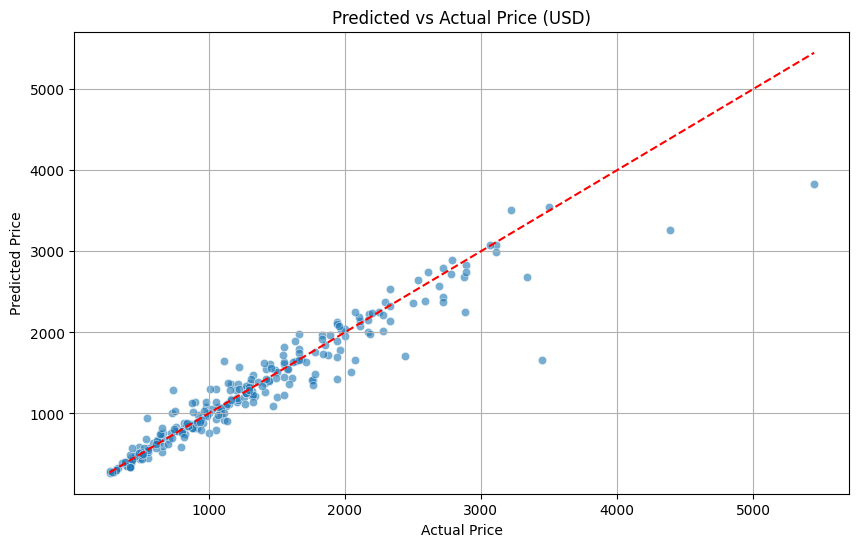

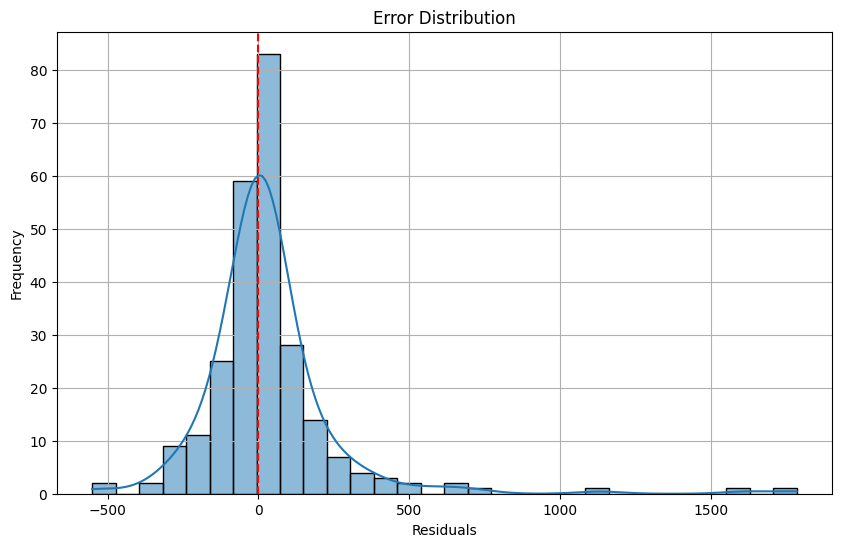

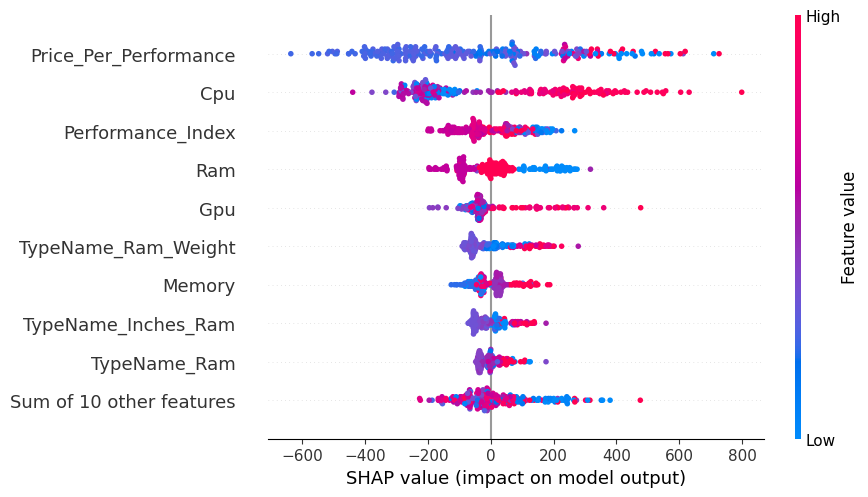

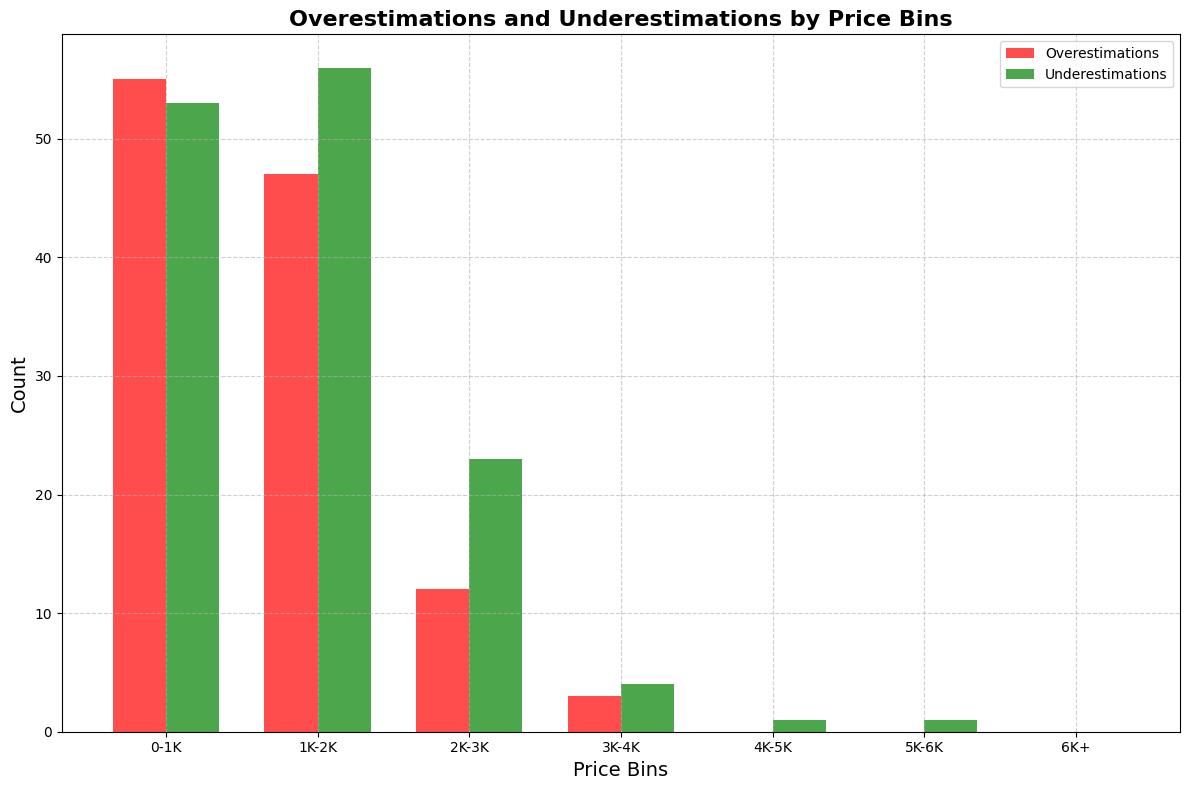

In [11]:
# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_new, y=y_pred_new, alpha=0.6)
sns.lineplot(x=[y_test_new.min(), y_test_new.max()], y=[y_test_new.min(), y_test_new.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Price (USD)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()


# Calculate residuals
residuals = y_test_new - y_pred_new

# Plot Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual (Perfect Prediction)')
plt.title("Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Calculate SHAP values
explainer = shap.Explainer(xgb_model_new, X_train_new)
shap_values = explainer(X_test_new)

# Plot SHAP beeswarm plot
shap.plots.beeswarm(shap_values)


# Define bins for price ranges
price_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
price_labels = ['0-1K', '1K-2K', '2K-3K', '3K-4K', '4K-5K', '5K-6K', '6K+']
y_test_binned = pd.cut(y_test_new, bins=price_bins, labels=price_labels)

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Actual Price': y_test_new,
    'Predicted Price': y_pred_new,
    'Residual': residuals,
    'Price Range': y_test_binned
})

# Calculate overestimations and underestimations by price range
over_under_estimations = analysis_df.groupby('Price Range').apply(
    lambda group: pd.Series({
        'Overestimations': (group['Residual'] < 0).sum(),
        'Underestimations': (group['Residual'] > 0).sum()
    })
).reset_index()

# Plot overestimations and underestimations by price range
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(over_under_estimations))

plt.bar(index, over_under_estimations['Overestimations'], bar_width, label='Overestimations', color='red', alpha=0.7)
plt.bar(index + bar_width, over_under_estimations['Underestimations'], bar_width, label='Underestimations', color='green', alpha=0.7)

plt.ylabel('Count', fontsize=14)
plt.xlabel('Price Bins', fontsize=14)
plt.title('Overestimations and Underestimations by Price Bins', fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, over_under_estimations['Price Range'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Analyzing the Improved Model

## A. Feature Importance

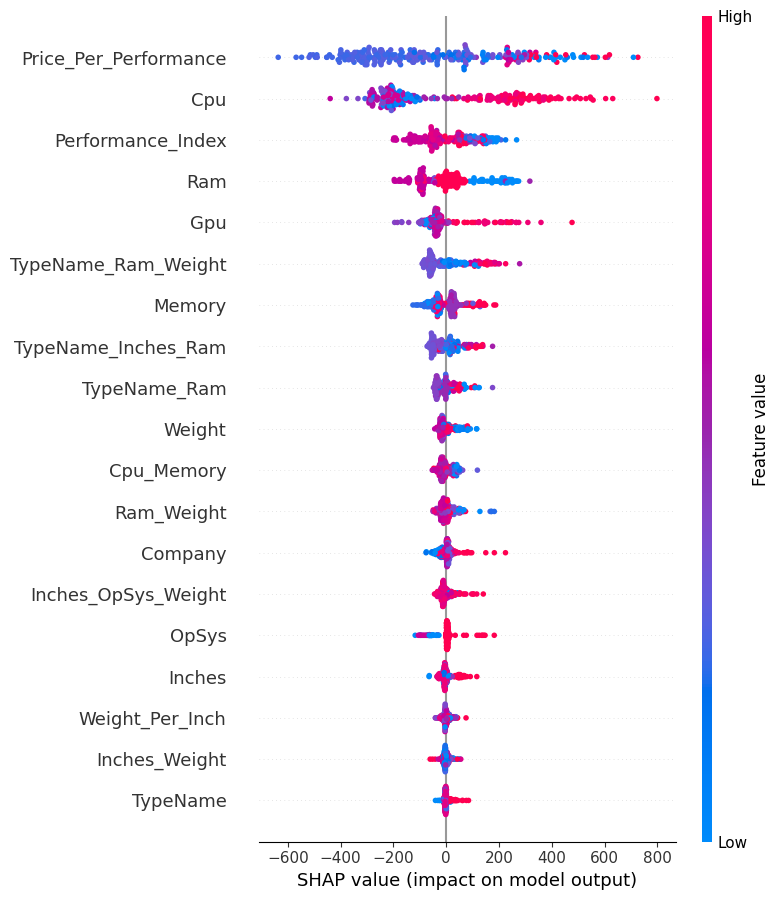

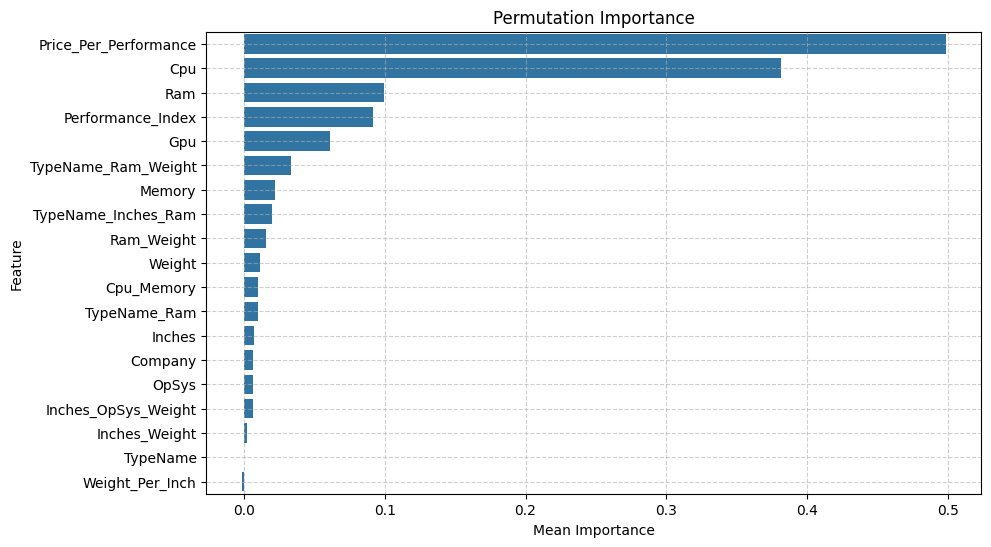

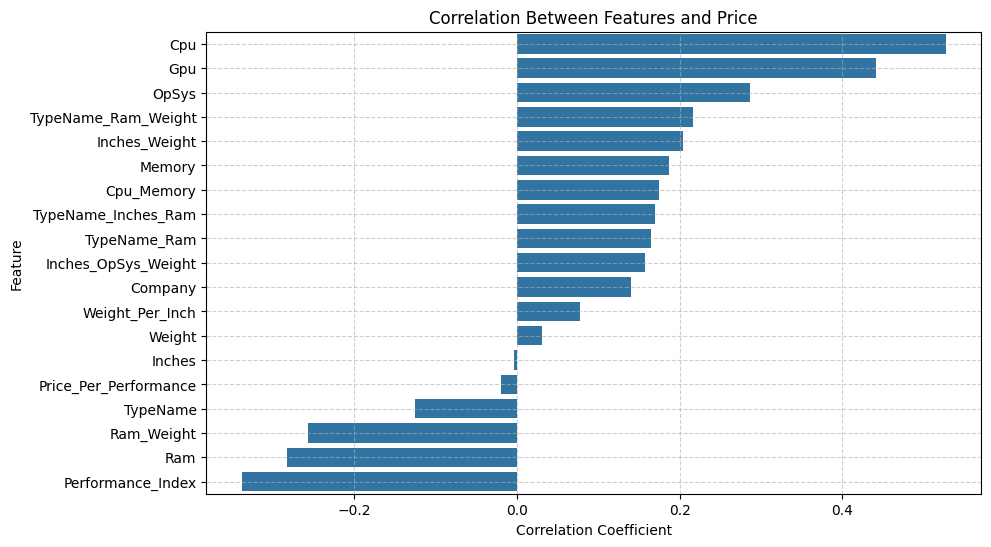

In [12]:
from sklearn.inspection import permutation_importance

# Calculate SHAP values
explainer = shap.Explainer(xgb_model_new, X_train_new)
shap_values = explainer(X_test_new)

# Summary plot
shap.summary_plot(shap_values, X_test_new)

# Permutation importance
perm_importance = permutation_importance(xgb_model_new, X_test_new, y_test_new, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importance
perm_df = pd.DataFrame({
    'Feature': X_test_new.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title("Permutation Importance")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Correlation matrix
correlation_matrix = improve_data.corr()

# Correlation with the target variable
target_corr = correlation_matrix['Price'].drop('Price').sort_values(ascending=False)

# Plot correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title("Correlation Between Features and Price")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Sort feature importances
sorted_importance = perm_df.sort_values(by='Importance', ascending=False)
sorted_importance['Cumulative Importance'] = sorted_importance['Importance'].cumsum()


## B. Compare Results Against the Baseline


Comparison of Model Performance Metrics:
Baseline RMSE: 313.30 USD, Improved RMSE: 232.72 USD
Baseline MAE: 193.69 USD, Improved MAE: 123.39 USD
Baseline R2 Score: 0.845, Improved R2 Score: 0.914
Old Model Pearson Correlation: 0.920
New Model Pearson Correlation: 0.959


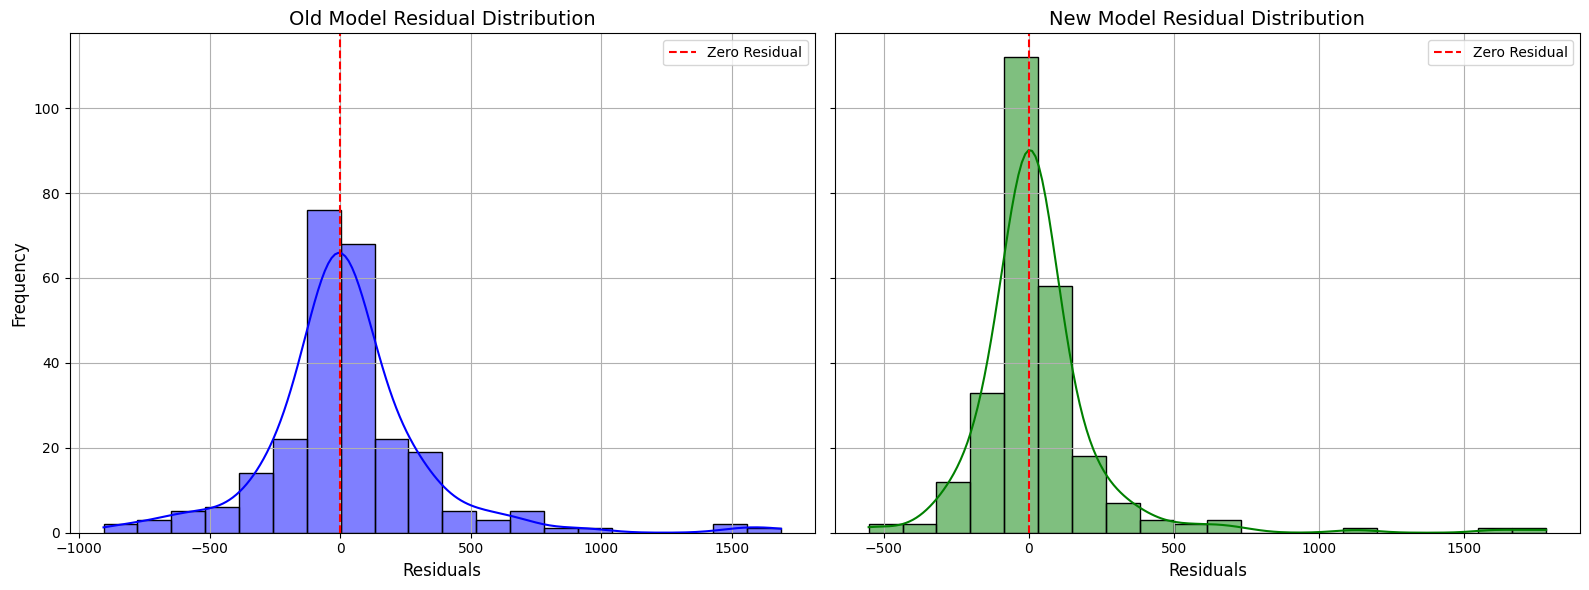

In [13]:
# Baseline model metrics
baseline_rmse = 313.30  # Example value from earlier results
baseline_mae = 193.69
baseline_r2 = 0.845

print("\nComparison of Model Performance Metrics:")
print(f"Baseline RMSE: {baseline_rmse:.2f} USD, Improved RMSE: {rmse_new:.2f} USD")
print(f"Baseline MAE: {baseline_mae:.2f} USD, Improved MAE: {mae_new:.2f} USD")
print(f"Baseline R2 Score: {baseline_r2:.3f}, Improved R2 Score: {r2_new:.3f}")


# Calculate Pearson correlation between actual and predicted
# Import necessary libraries
from scipy.stats import pearsonr

# Calculate Pearson correlation for the old model
y_pred_old = y_pred
residuals_old = y_test - y_pred_old
pearson_corr_old, _ = pearsonr(y_test, y_pred_old)
print(f"Old Model Pearson Correlation: {pearson_corr_old:.3f}")

# Calculate Pearson correlation for the new model
residuals_new = y_test_new - y_pred_new
pearson_corr_new, _ = pearsonr(y_test_new, y_pred_new)
print(f"New Model Pearson Correlation: {pearson_corr_new:.3f}")

# Create side-by-side plots for residual distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot residuals for the old model
sns.histplot(residuals_old, kde=True, bins=20, color='blue', ax=axes[0])
axes[0].axvline(x=0, color='red', linestyle='--', label='Zero Residual')
axes[0].set_title("Old Model Residual Distribution", fontsize=14)
axes[0].set_xlabel("Residuals", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Plot residuals for the new model
sns.histplot(residuals_new, kde=True, bins=20, color='green', ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='--', label='Zero Residual')
axes[1].set_title("New Model Residual Distribution", fontsize=14)
axes[1].set_xlabel("Residuals", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

